In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os

import matplotlib.pyplot as plt

import mediapipe as mp
import cv2
import tflite_runtime

from pathlib import Path

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_holistic = mp.solutions.holistic

from IPython.display import Image, display, Video


In [2]:
WLASL_DIR = Path('../raw_data/WLASL_processed')
WLASL_JSON_PATH = WLASL_DIR/'WLASL_v0.3.json'
WLASL_VIDEO_DIR = WLASL_DIR/'videos'

# WLASL Video Data

## Data description

Data source: https://www.kaggle.com/datasets/risangbaskoro/wlasl-processed/data (originally from https://github.com/dxli94/WLASL?tab=readme-ov-file)

### File Description
-----------------
The repository contains following files:

 * `WLASL_vx.x.json`: JSON file including all the data samples.

 * `data_reader.py`: Sample code for loading the dataset.

 * `video_downloader.py`: Sample code demonstrating how to download data samples.

 * `C-UDA-1.0.pdf`: the Computational Use of Data Agreement (C-UDA) agreement. You must read and agree with the terms before using the dataset.

### Data Description
-----------------

* `gloss`: *str*, data file is structured/categorised based on sign gloss, or namely, labels.

* `bbox`: *[int]*, bounding box detected using YOLOv3 of (xmin, ymin, xmax, ymax) convention. Following OpenCV convention, (0, 0) is the up-left corner.

* `fps`: *int*, frame rate (=25) used to decode the video as in the paper.

* `frame_start`: *int*, the starting frame of the gloss in the video (decoding
with FPS=25), *indexed from 1*.

* `frame_end`: *int*, the ending frame of the gloss in the video (decoding with FPS=25). -1 indicates the gloss ends at the last frame of the video.

* `instance_id`: *int*, id of the instance in the same class/gloss.

* `signer_id`: *int*, id of the signer.

* `source`: *str*, a string identifier for the source site.

* `split`: *str*, indicates sample belongs to which subset.

* `url`: *str*, used for video downloading.

* `variation_id`: *int*, id for dialect (indexed from 0).

* `video_id`: *str*, a unique video identifier.

Please be kindly advised that if you decode with different FPS, you may need to recalculate the `frame_start` and `frame_end` to get correct video segments.

## Exploratory Data Analysis

In [3]:
df = pd.read_json(WLASL_JSON_PATH)
df.head()

,gloss,instances
0,book,"[{'bbox': [385, 37, 885, 720], 'fps': 25, 'fra..."
1,drink,"[{'bbox': [551, 68, 1350, 1080], 'fps': 25, 'f..."
2,computer,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_..."
3,before,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_..."
4,chair,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_..."


In [4]:
# Explode the 'instances' column
df_unstacked = df.explode('instances').reset_index(drop=True)

# Normalize the 'instances' column containing dictionaries
instances_df = pd.json_normalize(df_unstacked['instances'])

# Combine the normalized 'instances' DataFrame with the original DataFrame
videos_df = pd.concat([df_unstacked.drop(columns=['instances']), instances_df], axis=1)

videos_df.head()

,gloss,bbox,fps,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id
0,book,"[385, 37, 885, 720]",25,-1,1,0,118,aslbrick,train,http://aslbricks.org/New/ASL-Videos/book.mp4,0,69241
1,book,"[190, 25, 489, 370]",25,-1,1,1,90,aslsignbank,train,https://aslsignbank.haskins.yale.edu/dictionar...,0,65225
2,book,"[262, 1, 652, 480]",25,-1,1,2,110,valencia-asl,train,https://www.youtube.com/watch?v=0UsjUE-TXns,0,68011
3,book,"[123, 19, 516, 358]",25,60,1,3,113,lillybauer,train,https://www.youtube.com/watch?v=1QOYOZ3g-aY,0,68208
4,book,"[95, 0, 1180, 720]",25,-1,1,4,109,valencia-asl,train,https://www.youtube.com/watch?v=aGtIHKEdCds,0,68012


In [5]:
def concat_video_path(path, video_id, video_format='mp4'):
    filename = f'{video_id}.{video_format}'
    video_path = os.path.join(path, filename)
    return video_path

In [6]:
# Check if file exists
def check_video_file(path, video_id, video_format='mp4'):
    video_path = concat_video_path(path, video_id, video_format)
    return os.path.isfile(video_path)

In [7]:
videos_df['file_exists'] = videos_df['video_id'].apply(lambda row : check_video_file(WLASL_VIDEO_DIR, row, 'mp4'))

videos_df.head()

,gloss,bbox,fps,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id,file_exists
0,book,"[385, 37, 885, 720]",25,-1,1,0,118,aslbrick,train,http://aslbricks.org/New/ASL-Videos/book.mp4,0,69241,True
1,book,"[190, 25, 489, 370]",25,-1,1,1,90,aslsignbank,train,https://aslsignbank.haskins.yale.edu/dictionar...,0,65225,False
2,book,"[262, 1, 652, 480]",25,-1,1,2,110,valencia-asl,train,https://www.youtube.com/watch?v=0UsjUE-TXns,0,68011,False
3,book,"[123, 19, 516, 358]",25,60,1,3,113,lillybauer,train,https://www.youtube.com/watch?v=1QOYOZ3g-aY,0,68208,False
4,book,"[95, 0, 1180, 720]",25,-1,1,4,109,valencia-asl,train,https://www.youtube.com/watch?v=aGtIHKEdCds,0,68012,False


In [8]:
videos_df['file_exists'].value_counts()

file_exists
True     11980
False     9103
Name: count, dtype: int64

In [9]:
# Keep only existing videos
videos_df = videos_df [videos_df['file_exists']].reset_index()

In [10]:
# Count words
videos_df[['gloss']].nunique()

gloss    2000
dtype: int64

In [11]:
# Videos per word

videos_per_gloss_df = videos_df[['gloss', 'video_id']].groupby('gloss').agg({'video_id':'count'}).rename(columns={'video_id':'n_videos'}).reset_index()
videos_per_gloss_df.head()

,gloss,n_videos
0,a,4
1,a lot,7
2,abdomen,5
3,able,5
4,about,7


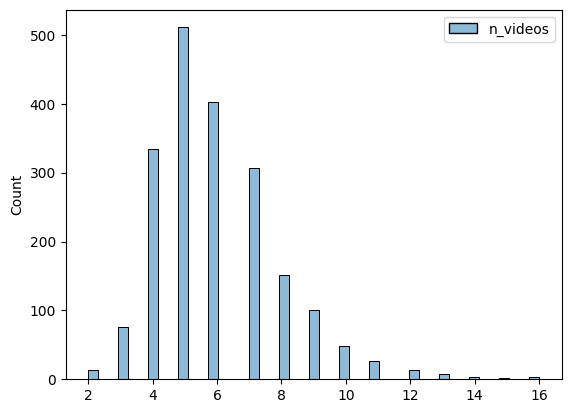

In [12]:
sns.histplot(videos_per_gloss_df);


## Video to landmarks (mediapipe)

https://www.kaggle.com/code/minnikeswarrao/video-to-mediapipe-parquet

In [13]:
def transform(path , start_frame , end_frame , fps):
    frame_number = 0
    frame = []
    type_ = []
    index = []
    x = []
    y = []
    z = []
    
    cap = cv2.VideoCapture(path)
    cap.set(cv2.CAP_PROP_FPS, fps)
    with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:
        while cap.isOpened():
            success, image = cap.read()
            if not success:
                break
            frame_number += 1
            if frame_number < start_frame:
                continue
            if end_frame != -1 and frame_number > end_frame:
                break
            image.flags.writeable = False
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            results = holistic.process(image)
            #face
            if(results.face_landmarks is None):
                for i in range(478):
                    frame.append(frame_number)
                    type_.append("face")
                    index.append(ind)
                    x.append(0)
                    y.append(0)
                    z.append(0)
            else:
                for ind,val in enumerate(results.face_landmarks.landmark):
                    frame.append(frame_number)
                    type_.append("face")
                    index.append(ind)
                    x.append(val.x)
                    y.append(val.y)
                    z.append(val.z)
            #pose
            if(results.pose_landmarks is None):
                for i in range(32):
                    frame.append(frame_number)
                    type_.append("pose")
                    index.append(ind)
                    x.append(0)
                    y.append(0)
                    z.append(0)
            else:
                for ind,val in enumerate(results.pose_landmarks.landmark):
                    frame.append(frame_number)
                    type_.append("pose")
                    index.append(ind)
                    x.append(val.x)
                    y.append(val.y)
                    z.append(val.z)
            #left hand
            if(results.left_hand_landmarks is None):
                for i in range(20):
                    frame.append(frame_number)
                    type_.append("left_hand")
                    index.append(ind)
                    x.append(0)
                    y.append(0)
                    z.append(0)
            else:
                for ind,val in enumerate(results.left_hand_landmarks.landmark):
                    frame.append(frame_number)
                    type_.append("left_hand")
                    index.append(ind)
                    x.append(val.x)
                    y.append(val.y)
                    z.append(val.z)
            #right hand
            if(results.right_hand_landmarks is None):
                for i in range(20):
                    frame.append(frame_number)
                    type_.append("right_hand")
                    index.append(ind)
                    x.append(0)
                    y.append(0)
                    z.append(0)
            else:
                for ind,val in enumerate(results.right_hand_landmarks.landmark):
                    frame.append(frame_number)
                    type_.append("right_hand")
                    index.append(ind)
                    x.append(val.x)
                    y.append(val.y)
                    z.append(val.z)
            
    return pd.DataFrame({
        "frame" : frame,
        "type"  : type_,
        "landmark_index" : index,
        "x" : x,
        "y" : y,
        "z" : z
    })

In [14]:
word = 'hello'
word_mask = videos_df['gloss'] == word

video = videos_df[word_mask].iloc[0]

video_id = video.video_id
video_file = video_id + '.mp4'
video_path = os.path.join(WLASL_VIDEO_DIR, video_file)

Video(url=video_path, width=400)

In [15]:
start_frame = video.frame_start
end_frame = video.frame_end
fps = video.fps
sign = transform(video_path , start_frame , end_frame , fps)
sign.y = - 1 * sign.y

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [16]:
sign

,frame,type,landmark_index,x,y,z
0,1,face,0,0.502173,-0.350362,-0.011106
1,1,face,1,0.502217,-0.326035,-0.020047
2,1,face,2,0.501977,-0.333661,-0.010450
3,1,face,3,0.498808,-0.302896,-0.014954
4,1,face,4,0.502213,-0.318750,-0.021292
...,...,...,...,...,...,...
49809,92,right_hand,32,0.000000,-0.000000,0.000000
49810,92,right_hand,32,0.000000,-0.000000,0.000000
49811,92,right_hand,32,0.000000,-0.000000,0.000000
49812,92,right_hand,32,0.000000,-0.000000,0.000000


In [17]:
sign[(sign.type=='right_hand') & (sign.x>0)]

,frame,type,landmark_index,x,y,z
16751,31,right_hand,0,0.358445,-0.926320,1.955940e-08
16752,31,right_hand,1,0.375054,-0.929763,-6.767998e-03
16753,31,right_hand,2,0.391133,-0.948650,-1.266609e-02
16754,31,right_hand,3,0.400048,-0.968649,-1.752313e-02
16755,31,right_hand,4,0.403993,-0.988845,-2.199413e-02
...,...,...,...,...,...,...
35193,65,right_hand,16,0.396245,-1.071696,-8.527956e-03
35194,65,right_hand,17,0.381215,-0.979583,-1.150445e-02
35195,65,right_hand,18,0.383298,-1.020834,-1.083946e-02
35196,65,right_hand,19,0.382250,-1.042363,-7.960084e-03


In [18]:
# from matplotlib.animation import FuncAnimation
# from IPython.display import HTML

# def animation_frame(f):
#     frame = sign[sign.frame==f]
#     left = frame[frame.type=='left_hand']
#     right = frame[frame.type=='right_hand']
#     pose = frame[frame.type=='pose']
#     face = frame[frame.type=='face'][['x', 'y']].values
#     lx, ly = get_hand_points(left)
#     rx, ry = get_hand_points(right)
#     px, py = get_pose_points(pose)
#     ax.clear()
#     ax.plot(face[:,0], face[:,1], '.')
#     for i in range(len(lx)):
#         ax.plot(lx[i], ly[i])
#     for i in range(len(rx)):
#         ax.plot(rx[i], ry[i])
#     for i in range(len(px)):
#         ax.plot(px[i], py[i])
#     plt.xlim(xmin, xmax)
#     plt.ylim(ymin, ymax)
        
# ## These values set the limits on the graph to stabilize the video
# xmin = sign.x.min() - 0.2
# xmax = sign.x.max() + 0.2
# ymin = sign.y.min() - 0.2
# ymax = sign.y.max() + 0.2

# fig, ax = plt.subplots(1)
# l, = ax.plot([], [])
    
# animation = FuncAnimation(fig, func=animation_frame, frames=range(40,45)) # doees not work when hand not detected

# HTML(animation.to_html5_video())